In [44]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.crs as crs
import cartopy.feature as cfeature
import h5py  
from astropy.time import Time
import os
import glob
from osgeo import gdal
import scipy.ndimage
import rasterio as rio
import re
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
from pyhdf.SD import SD, SDC
import pprint
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import csv
import pprint
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 

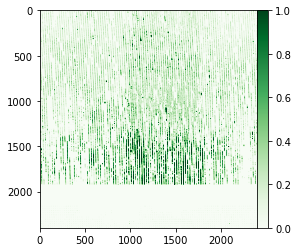

In [2]:
# ignore this first cell
canopy_height_array = pd.read_csv("D:\\masters_data\\output\\csv\\total_canopy_height_array_(meancanopyfile).csv", header=None)
fig, axes = plt.subplots() 
img = axes.imshow(canopy_height_array,vmin=0, vmax=1, cmap = "Greens") 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
color_bar = plt.colorbar(img, cax = cax) 
plt.show()

In [3]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\rainfall"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [70]:
# select first MODIS file
IMERGFiles = glob.glob('*IMERG*')
IMERG = h5py.File(IMERGFiles[8], 'r')

In [71]:
precipitation = IMERG['/Grid/precipitation/'][:]
precipitation = np.transpose(precipitation)
latitude = IMERG['/Grid/lat'] [:]
longitude = IMERG['/Grid/lon'][::]

In [75]:
precipitation[precipitation ==0] = np.nan

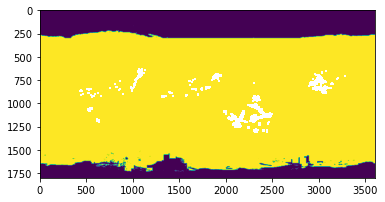

In [77]:
color_map = plt.imshow(precipitation)
img = axes.imshow(precipitation, cmap = "jet")
plt.colorbar(img, cax = cax)
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")
color_bar = plt.colorbar(img, cax = cax) 
plt.show()

In [78]:
rainfall = np.zeros((2400,2400))

In [79]:
lon_number = 0
r_list = []
c_list = []

for i in longitude:
    lat_number = 0
    for i in latitude:
        lat = latitude[lat_number]
        lon = longitude[lon_number]

In [80]:
# constants for conversion lat lon -> tile H,V and r,c
R = 6371007.181	    # the radius of the idealizes sphere representing the Earth
T = 1111950	        # the height and width of each MODIS tile in the projection plane
Xmin = -20015109    # the western limit of the projection plane
Ymax = 10007555	    # the northern limit of the projection plane
w = T/2400.0	    # the actual size of a '500m' MODIS sinusoidal grid cell. (would be /1200 for a 1km grid)

In [81]:
# Forward Mapping
# First compute the position of the point on the global sinusoidal grid:

phi = lat/(180/math.pi)
lamb = lon/(180/math.pi)
x = R*lamb*math.cos(phi)
y = R*phi
H = int(math.floor((x - Xmin)/T))
V = int(math.floor((Ymax - y)/T))
r = int(math.floor(((Ymax-y)%T)/w-0.5))
c = int(math.floor(((x-Xmin)%T)/w-0.5))

In [83]:
# converting precipitation 3D array into a list 
precip_list = []

lon_number = 0

for i in range(len(latitude)):
    lat_number = 0
    for i in range(len(longitude)):
        precip_value = precipitation[lon_number][lat_number][0]
        precip_list.append(precip_value)
        lat_number += 1
    lon_number +=1

In [84]:
lon_number = 0
H_list = []
V_list = []
r_list = []
c_list = []

for i in longitude:
    lat_number = 0
    for i in latitude:
        lat = latitude[lat_number]
        lon = longitude[lon_number]
        phi = lat/(180/math.pi) # convert to radians
        lamb = lon/(180/math.pi)
        x = R*lamb*math.cos(phi)
        y = R*phi
        H = int(math.floor((x - Xmin)/T))
        V = int(math.floor((Ymax - y)/T))
        r = int(900-np.ceil(lat*10))
        c = int(np.floor(lon*10)+1800)

        H_list.append(H)
        V_list.append(V)
        r_list.append(r)
        c_list.append(c)
        lat_number += 1
    lon_number += 1

In [85]:
H_list_array = np.array(H_list)
V_list_array = np.array(V_list)
r_list_array = np.array(r_list)
c_list_array = np.array(c_list)
precip_list_array = np.array(precip_list)

In [86]:
mask = (H_list_array == 20) * (V_list_array == 8)

In [87]:
row_selected = r_list_array[mask == 1]
col_selected = c_list_array[mask == 1]
precip_selected = precip_list_array[mask == 1]

In [88]:
for i in range(len(row_selected)):
    row = row_selected[i]
    col = col_selected[i]
    rainfall[row, col] = precip_selected[i]

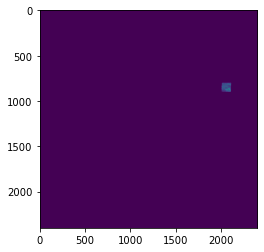

In [90]:
color_map = plt.imshow(rainfall)
img = axes.imshow(rainfall, cmap = "jet")
plt.colorbar(img, cax = cax)
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")
color_bar = plt.colorbar(img, cax = cax) 
plt.show()